<a href="https://colab.research.google.com/github/hwarang97/hukppenhiem/blob/main/%5Bprac%5DDacon_pytorch_day3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [39]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
data_path = '/content/drive/MyDrive/Colab Notebooks/data'
LR = 1e-3 # 잘못 설정하면 loss값이 이상하게 나타남
BATCH_SIZE = 32
EPOCH = 5
criterion = nn.CrossEntropyLoss()
dataset = 'MNIST'
model_type = 'MLP'
is_new_model = False
save_path = f'/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{dataset}.pt'

In [41]:
trainset = datasets.MNIST(data_path, train=True, transform=transforms.ToTensor(), download=True)
testset = datasets.MNIST(data_path, train=False, transform=transforms.ToTensor(), download=True)
train_DL = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
test_DL = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [42]:
class MLP(nn.Module):
    def __init__(self, drop_p):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(drop_p),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(drop_p),
            nn.Linear(128,10)
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

In [43]:
def Train(model, train_DL, optimizer):
    model.train()
    NoT = len(train_DL.dataset)
    loss_history = []
    for epoch in range(1, 1+EPOCH):
        e_loss = 0
        for x_batch, y_batch in train_DL: # x_batch로 바꾸는게 더 좋겠다
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            e_loss += loss.item() * x_batch.shape[0] # 32
        e_loss /= NoT
        loss_history += [e_loss]

        print(f'epoch at {epoch}   loss : {e_loss}')
        print('-'*25)



    plt.plot(loss_history)

In [44]:
def Test(model, test_DL, optimizer):
    model.eval()
    NoT = len(test_DL.dataset)

    with torch.no_grad():
        b_correct = 0
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            y_hat = model(x_batch)
            pred = y_hat.argmax(dim=1)

            # 몇개 맞추었는지 확인
            correct = torch.sum(pred == y_batch).item() # item 안빼먹도록 조심
            b_correct += correct

        accuracy = b_correct / NoT * 100
    print(f'accuracy : {accuracy} ({round(accuracy,3)}%)')

In [45]:
exec(f'model = {model_type}(0.2)')
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

if is_new_model :
    model = model.to(DEVICE)
    Train(model, train_DL, optimizer)

In [46]:
if is_new_model:
    torch.save(model, '/content/drive/MyDrive/Colab Notebooks/results/MLP_MNIST.pt')

In [47]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/results/MLP_MNIST.pt', map_location=DEVICE)

In [48]:
Test(model, test_DL, optimizer)

accuracy : 98.09 (98.09%)


In [49]:
def test_plot(model, test_DL):
    model.train()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL))
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        y_hat = model(x_batch)
        pred = y_hat.argmax(dim=1)

    x_batch = x_batch.to('cpu')

    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2,3,idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze(), cmap='gray')
        pred_class = test_DL.dataset.classes[pred[idx]]
        true_class = test_DL.dataset.classes[y_batch[idx]]
        plt.title(f'{pred[idx]} = ({y_batch[idx]})', color='g' if pred[idx] == y_batch[idx] else 'r')

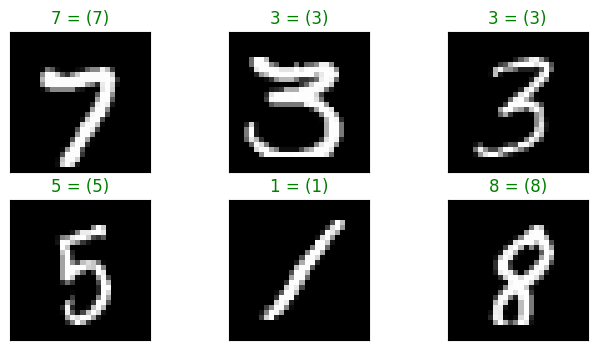

In [50]:
test_plot(model, test_DL)